# Simplified Indoor Design

Now that we have a way to get aerodynamic data for our airfoils, we need to look at the force arrangement on a typical model. To draw nice diagrams in a Jupyter page, I use the *TikZ* graphics package available from the $\LaTeX$ typesetting software tool used by many researchers to create professional documents. The code you will see here is a bit complicated, so you really only need to look at the final product. 

Here is the general layout of the model forces: 

In [2]:
%reload_ext tikzmagic

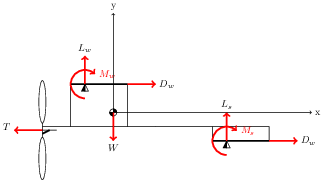

In [3]:
%%tikz -l calc

% draw axes

\draw[thin,->] (2.5,0.5) -- (2.5,4) node[above]{y};
\draw[thin,->] (2.5,0.5) -- (9.5,0.5) node[right]{x};

\newcommand{\model}{
    % body line
    \draw (0,0) -- (4,0);
    %tail boom line
    \draw (4,0) -- (8,0);
    \draw (1,0) -- (1,1.5);
    \draw (3,0) -- (3,1.5);
    
    % wing
    \draw [ultra thick] (1,1.5) -- (3,1.5);
    \draw (6,0) -- (6,-0.5);
    \draw (8,0) -- (8,-0.5);
    \draw [ultra thick] (8,-0.5) -- (6,-0.5);
    
    % prop
    \draw (0,-0.375) -- (0,0.125);
    \draw (0,-1.125) ellipse (0.125 and 0.75);
    \draw (0,0.875) ellipse (0.125 and 0.75);
    \draw[thin] (0,-0.125) -- (0.5,-0.125);
}

\newcommand{\wingac}[2] {
    \draw[fill=black] (#1,#2) -- (#1-0.125,#2-0.25) -- (#1, #2-0.25) -- cycle;
    \draw (#1,#2) -- (#1+0.125,#2-0.25) -- (#1, #2-0.25) -- cycle;
}

\newcommand{\cg}[2]{
    \draw [fill=black](#1,#2) -- 
        ++(+0.125,0) arc (0:90:0.125) -- 
        ++(0,-0.25) arc (270:180:0.125) -- (#1,#2);%
        \draw (#1,#2) circle (0.125);%
}
\model
\wingac{1.5}{1.5}
\wingac{6.5}{-0.5}
\cg{2.5}{0.5}

% wing lift and drag
\draw[red,ultra thick,->] (1.5,1.5) -- (1.5,2.5);
\node[above] at (1.5,2.5) {$L_w$};
\draw[red,ultra thick,->] (3,1.5) -- (4,1.5);
\node[right] at (4,1.5) {$D_w$};
            
% stab lift and drag
\draw[red,ultra thick,->] (6.5,-0.5) -- (6.5,0.5);
\node[above] at (6.5,0.5) {$L_s$};
\draw[red,ultra thick,->] (8,-0.5) -- (9,-0.5);
\node[right] at (9,-0.5) {$D_w$};

% Moments
\draw [red,ultra thick,->] (1.5,1.0) arc (-90:-315:0.5) 
            node[right] {$M_w$};
\draw [red,ultra thick,->] (6.5,-1) arc (-90:-315:0.5) 
            node[right] {$M_s$};                
% thrust
\draw[red,ultra thick, ->] (0,-0.125) -- (-1,-0.125);
\node[left] at (-1,0) {$T$};
\draw[ultra thick] (0,-0.25) -- (0.25,-0.125);
            
% weight
\draw[red,ultra thick,->] (2.5,0.5) -- (2.5,-0.5);
\node[below] at (2.5,-0.5) {$W$};          

This diagram also shows the forces acting on the model. The lift and drag forces are assumed to act at the aerodynamic centers of the lifting surfaces.  For simplicity, these centers are located at the quarter-chord point on both surfaces. I will be locating all points shown in his diagram using actual dimensional data from Gary’s *Wart* plan in the example calculations.

## Locating the Center of Gravity

The location of the center of gravity is important in our analysis, but that location is not shown in Gary’s plan. However, he does provide weight data for the major model components.

Here are the weights from the plans:

In [1]:
import pint
u = pint.UnitRegistry()

In [2]:
weights = {
    'motor_stick': 0.22*u.grams,
    'tail_boom': 0.08*u.grams,
    'stab': 0.25*u.grams,
    'wing': 0.42*u.grams,
    'prop': 0.23*u.grams,
    'rubber': 0.86*u.grams
}

Here is a bit of code that calculates the total weight:

In [3]:
total_weight = 0
for key in weights:
    total_weight += weights[key]
    
print('total weight = ',total_weight)

total weight =  2.06 gram


We can estimate the **CG** location by balancing the model, both horizontally, and vertically.

The definition of the *center of mass* for a collection of objects is:

\begin{equation}
{cg}_x = \frac{\sum^{n}_{i=1}x_i W_i}{\sum^{n}_{i=1}W_i}
\end{equation}

\begin{equation}
{cg}_y = \frac{\sum^{n}_{i=1}y_i W_i}{\sum^{n}_{i=1}W_i}
\end{equation}

The reference point for these calculations can be any convenient point. We will use the nose of the motor stick. All dimensions were derived from the plans.

(TODO: The exact center of mass for the wing and stab should be calculated using *OpenSCAD*.

In [5]:
cg_arms = {
    'prop': (0*u.inch,-0.125*u.inch),
    'wing': (2.25*u.inch, (7/8)*u.inch),
    'stab': ((6+8.5-1)*u.inch,0*u.inch),
    'motor_stick': (4*u.inch,0.0625*u.inch),
    'tail_boom': (7.0*u.inch,0*u.inch),
    'rubber': (3*u.inch,-0.125*u.inch)
}

Each of these locations is. shown as an **(x,y)** pair. We need both values to locate the **CG** correctly. Yes, it is tedious to add units to the numbers, but the results will justify adding them.

Here is code to calculate the model weight:

In [6]:
   def cg(w,a):
    x_cg = 0
    y_cg = 0
    W_sum = 0
    for key in w:
        x_cg += w[key] * a[key][0]
        y_cg += w[key] * a[key][1]
        W_sum += w[key]
    x_cg = x_cg/W_sum
    y_cg = y_cg/W_sum
    print(f'CG is at ({x_cg},{y_cg})')
        
cg(weights, cg_arms)

CG is at (4.048543689320388 inch,0.11893203883495145 inch)


That puts the **CG** slightly behind the tailing edge of the wing. 

Before we move on, let's gather some data from the plans and calculate a few area and lengths we will need.

In [7]:
import math

# define basic dimensions from plan
wing = {
    'center_span': 8 * u.inches,
    'center_chord': 2 * u.inches,
    'tip_span':3.75 * u.inches,
    'tip_chord': 1.75 * u.inches,
    'tip_dihedral': 7/8*u.inches,
}

stab = {
    'tip_span': (5 + 7/16) * u.inches,
    'center_chord': 1.75 * u.inches,
    'tip_chord': 1 * u.inches,
    'tip_dihedral': 7/8 * u.inches
}

## add calculated dimensions needed in later work
wing['tip_angle'] = math.atan(wing['tip_dihedral']/wing['tip_span'])
stab['tip_angle'] = math.atan(stab['tip_dihedral']/stab['tip_span']/2)
wing['projected_area'] = \
    wing['center_span'] * wing['center_chord'] \
     + 2 * (wing['center_chord'] + wing['tip_chord'])/2 *\
    wing['tip_span'] * math.cos(wing['tip_angle'])
stab['projected_area'] = 2 * stab['tip_span'] * (stab['center_chord'] 
                + stab['tip_chord'] )/2\
         * math.cos(stab['tip_angle'])
stab['projected_span'] = 2 * stab['tip_span'] * math.cos(stab['tip_angle'])
wing['projected_span'] = wing['center_span'] + 2 * \
    wing['tip_span'] * math.cos(wing['tip_angle'])
wing['mean_chord'] = wing['projected_area']/wing['projected_span']
stab['mean_chord'] = stab['projected_area']/stab['projected_span']
stab['te_to_ac'] = 0.75 * stab['mean_chord']
wing['te_to_ac'] = 0.75 * wing['mean_chord']

Here is a utility routine to print our the data we have created:

In [8]:
def print_dict(d, title):
    print(title)
    for key in d:
        print(f'\t{key}: {d[key]}')

In [9]:
print_dict(wing,"wing data")
print_dict(stab, "stab_data")

wing data
	center_span: 8 inch
	center_chord: 2 inch
	tip_span: 3.75 inch
	tip_chord: 1.75 inch
	tip_dihedral: 0.875 inch
	tip_angle: 0.22923193327699534
	projected_area: 29.694642011993967 inch ** 2
	projected_span: 15.303809073063448 inch
	mean_chord: 1.940343209342576 inch
	te_to_ac: 1.4552574070069322 inch
stab_data
	tip_span: 5.4375 inch
	center_chord: 1.75 inch
	tip_chord: 1 inch
	tip_dihedral: 0.875 inch
	tip_angle: 0.08028681528301647
	projected_area: 14.90495716456054 inch ** 2
	projected_span: 10.83996884695312 inch
	mean_chord: 1.375 inch
	te_to_ac: 1.03125 inch


## Aerodynamic Centers

Flying surfaces generate aerodynamic forces by creating a pressure distribution on their surfaces as they move. We can integrate this pressure distribution to find the total force that will be generated, and locate that force. This point is called the *center of pressure*. Unfortunately, the center of pressure  point varies with angle of attack. For that reason, aerodynamics researchers prefers to use an *aerodynamic center* as the point where forces will be applied. Doing this requires the addition of a moment force to ensure that the total force are correct. The aerodynamic center is commonly set at 1/4 of the mean chord of each surface. 

The mean chord is found using:

\begin{equation}
c_m = S / b
\end{equation}

Where $S$ is the projected surface area, and $b$ is the projected span.

## Aerodynamic Forces

To take the next step in analyzing this model, we need to figure out the aerodynamic forces that are generated by the lifting surfaces. We have airfoil data we can use as a start. However, to use that data to generate the forces acting on the model, we need to know how fast the model will be flying. How can we figure that out?

### Level Flight

In level flight, all four major forces are balanced: lift equals weight, and thrust equals drag.  We also need to balance the moments produced by those forces about the center of gravity. In stable level flight, the sum of all those moments must equal zero. 

Once you launch the model, it will seek out a flight configuration where the forces try to balance.  If you have not adjusted the trim settings properly, your airplane might stall, or head to the floor. Gary constructed the Wart with the wing aligned with the motor stick at 0 degrees incidence and the stab set at about -2 degrees incidence. The model certainly did not fly at zero degrees angle of attack, but what angle did it assume?  That angle has nothing to do with the angle the airplane assumed during the climb. The angle we are talking about here is the angle relative to the actual model flight path through the air. During the climb, the model may head up at 30 degrees, but if you watch, the model is angled up some amount as well. The angle of attack during the climb is the difference between those two angles, which is not 30 degrees. Since the lift and drag forces are determined by that angle of attack, we again seem to be stuck in our calculations. How can we figure this angle out? 

In McLean’s method, he sidestepped this whole issue and set the lift coefficient of the wing at 1.0, then calculated the stabilizer lift coefficient needed to make the moments sum to zero. He ignored the drag forces in his calculations. Those assumptions certainly simplify the calculations, but again, we are leaving out the actual model.

Let’s try a different approach that uses available airfoil data and model dimensions. First we define the moment arms for each force relative to the CG.

In [10]:
arms = {
    'thrust': (-2.5 * u.inch, -0.125*u.inch),
    'weight': (0*u.inch,0*u.inch),
    'wing_ac': (-1*u.inch,1*u.inch),
    'stab_ac': (4*u.inch,-1*u.inch),
}

In [13]:
forces = {
    'thrust': 0.05*u.grams,
    'weight': 2.06*u.grams,
    'lift_wing': 1.5*u.grams,
    'drag_wing': 0.03*u.grams,
    'lift_stab': -0.4*u.grams,
    'drag_stab': 0.015*u.grams
}

Here is a utility routine to print our the data we have created:

In [14]:
def print_dict(d, title):
    print(title)
    for key in d:
        print(f'\t{key}: {d[key]}')

We can now write a simple function that determines the moment around the **CG** for given values of the various terms. To simplify this function, we will create a Python dictionary holding the values.

It should be apparent that all six force vectors need to be considered, since none of them (except weight) align with the center of gravity. 

We need to estimate the location of the center of gravity. The Wart plans shows some data we can use:

In [15]:
def moment(a,f, debug=False):
    
    # thrust moment
    ta = a['thrust'][1] # y 
    tf = f['thrust']
    tm = ta * tf
    if debug:
        print("Thrust moment:",tm)
    # weight  - no moment, but we will calculate it anyway
    wa = a['weight'][0]
    wf = f['weight']
    wm = wa * wf
    if debug:
        print("Weight moment:",wm)
    
    # wing lift moment
    wla = a['wing_ac'][0]
    wlf = f['lift_wing']
    wlm = wla * wlf
    if debug:
        print("Wing lift moment:",wlm)
    
    # wing drag moment
    wda = a['wing_ac'][1]
    wdf = f['drag_wing']
    wdm = wda * wdf
    if debug:
        print("Wing drag moment:",wdm)    
    
    # stab lift moment
    sla = a['stab_ac'][0]
    slf = f['lift_stab']
    slm = sla * slf
    if debug:
        print("Stab lift moment:",slm)    
    
    # stab drag moment
    sda = a['stab_ac'][1]
    sdf = f['drag_stab']
    sdm = sda * sdf 
    if debug:
        print("Stab drag moment:",sdm)
        
    total_moment = tm + wm + wlm + wdm + slm + sdm 
    print('total moment =',total_moment)


In [16]:
moment(arms, forces, debug=True)

Thrust moment: -0.00625 gram * inch
Weight moment: 0.0 gram * inch
Wing lift moment: -1.5 gram * inch
Wing drag moment: 0.03 gram * inch
Stab lift moment: -1.6 gram * inch
Stab drag moment: -0.015 gram * inch
total moment = -3.09125 gram * inch


By convention, a positive moment pitched the node up. So this one is going to fly about like many of my  first flights!

For stable level flight, the total moment needs to be zero. Obviously, I threw in random values here, and our goal is to produce all of these numbers from our design and a little help from aerodynamics theory.

The nice thing about using code to help us make these calculations is that we can run parametric tests and see results quickly, We will use that fact later.

## Aerodynamic forces

The forces generated by the wing and stab depend on the airfoils we use and the actual flight conditions. Since most bulders use simple circular arc airfoils, I went in search of data on common thicknesses. The Wart uses a 4% arc on the wing, and a 2% arc on the stab. Of course, I could not find any usable data for those airfoils, but I did find data for a 6% and a 3% arc airfoils that will at least let us begin this development.

The lift and drag forces will be calculated using the definitions of the lift and drag coefficients:
    
\begin{equation}
C_l = \frac{2L}{\rho u^2 S}
\end{equation}

or

\begin{equation}
L = \frac{1}{2}\rho u^2 C_l S
\end{equation}

In these equations, **L** and **D** are the lift forces, **S** is the surface area of the wing or stab, $\rho$ is the air density and **u** is the flight velocity. 

Similarly:

\begin{equation}
D = \frac{1}{2}\rho u^2 C_d S
\end{equation}

Formally, we should also include the moment coefficient, which accounts for the center of pressure not falling exactly at the aerodynamic center

\begin{equation}
M = \frac{1}{2}\rho u^2 C_n S c
\end{equation}

Where **c** is the mean chord.

For testing purposes, we will use these values for density and velocity:



In [17]:
flight = {
    'density': 0.00231683 *u.slugs/u.ft**3,
    'dynamic_viscosity': 0.0000180338 * u.pascal * u.second,
    'velocity': 2.94 * u.mph
}
flight['kinematic_viscosity'] = flight['dynamic_viscosity']/flight['density']
flight['q'] = 0.5* (flight['density'] * flight['velocity'] ** 2)
flight['wing_re'] = flight['density'] * flight['velocity'] * wing['mean_chord'] / flight['dynamic_viscosity']
flight['stab_re'] = flight['density'] * flight['velocity'] * stab['mean_chord'] / flight['dynamic_viscosity']

print_dict(flight, "Flight Data")

Flight Data
	density: 0.00231683 slug / foot ** 3
	dynamic_viscosity: 1.80338e-05 pascal * second
	velocity: 2.94 mile_per_hour
	kinematic_viscosity: 0.007783825313035483 foot ** 3 * pascal * second / slug
	q: 0.010012875894 mile_per_hour ** 2 * slug / foot ** 3
	wing_re: 732.8798895208671 inch * mile_per_hour * slug / foot ** 3 / pascal / second
	stab_re: 519.346187436924 inch * mile_per_hour * slug / foot ** 3 / pascal / second


In [18]:
wing_re = flight['wing_re'].to_base_units()
wing_re

4288.836311434772 <Unit('dimensionless')>

In [19]:
stab_re = flight['stab_re'].to_base_units()
stab_re

3039.2303278247737 <Unit('dimensionless')>